# Generate Computer Vision Data without any images

---------------
In computer vision, effectively handling rare classes is crucial for accurate model performance, especially in applications like biodiversity monitoring and autonomous driving. Techniques such as data augmentation and synthetic data generation can enhance model generalization for these underrepresented classes



#### Tools Used:
- Diffusion Model to generate Images: We'll use Stable Diffusion 3
- Grounding Dino: to generate Detection and Segmentation Data

#### Load Libraries

In [3]:
import torch
from diffusers import StableDiffusion3Pipeline
import requests
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

#### Load Diffusion Model to generate images using Descriptions

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

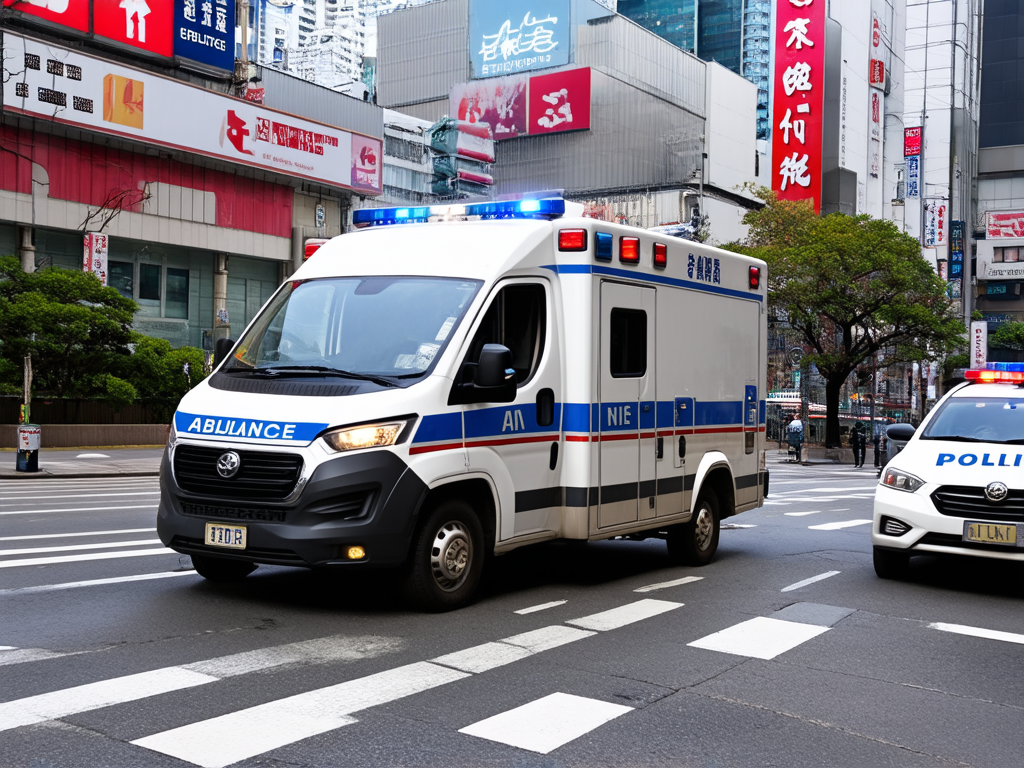

In [7]:
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
def generate_images(pipe, description):
    image = pipe(
        description,
        negative_prompt="",
        height=768,
        width=1024,
        num_inference_steps=28,
        guidance_scale=7.0,
    ).images[0]
    return image
description = 'An Image of Ambulance running on the streets of Tokyo with police car on side'
generated_image = generate_images(pipe, description)
display(generated_image)

#### Observations

- In the above image, which is Diffusion model generated is completely based on the description

#### Load the grounding dino model to generate the detections on the above image

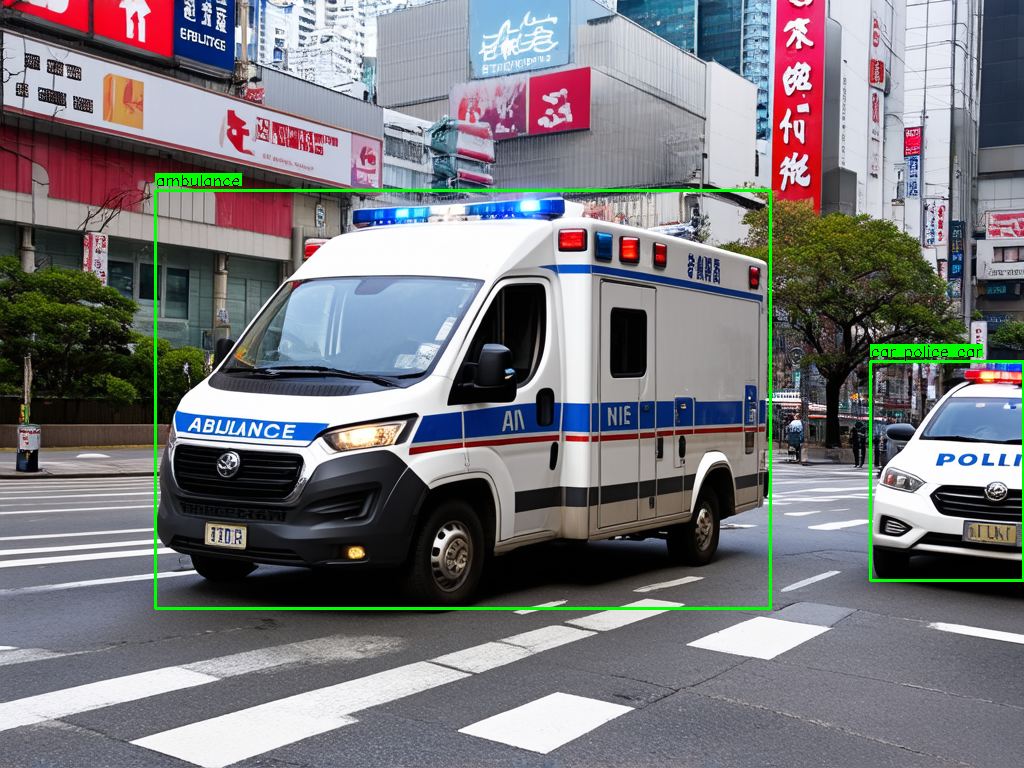

In [13]:
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)


# Check for cats and remote controls
text = "ambulance. car. police car."

def detect_boxes(image, text):
    inputs = processor(images=generated_image, text=text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.4,
        text_threshold=0.3,
        target_sizes=[generated_image.size[::-1]]
    )[0]
    boxes = results['boxes'].cpu().numpy().tolist()
    labels = results['labels']
    return boxes, labels


def visualize_detector(image, boxes, labels):
    """
    Merge detections from patches and draw bounding boxes on the original image.

    Args:
        image (PIL image): Original image.
        detections (list): List of detections for each patch.
        positions (list): List of top-left corner coordinates for each patch.
        patch_size (int): Size of each patch.

    Returns:
        PIL Image: Image with drawn bounding boxes and labels.
    """
    image = np.array(image)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    #semantic_array = np.array(Image.open(semantic_mask))
    for box, label in zip(boxes, labels):
        # Adjust box coordinates to the original image
        x1, y1, x2, y2 = box

        # Draw bounding box
        cv2.rectangle(
            image,
            (int(x1), int(y1)),
            (int(x2), int(y2)),
            color=(0, 255, 0),
            thickness=2,
        )

        # Put label and score
        label_text = f"{label}"
        text_size = cv2.getTextSize(label_text, font, font_scale, thickness)[0]
        text_x = int(x1)
        text_y = int(y1) - 5
        if text_y < 0:  # Ensure text doesn't go out of bounds
            text_y = int(y1) + text_size[1] + 5
        cv2.rectangle(
            image,
            (text_x, text_y - text_size[1]),
            (text_x + text_size[0], text_y),
            (0, 255, 0),
            -1,
        )
        cv2.putText(
            image,
            label_text,
            (text_x, text_y),
            font,
            font_scale,
            (0, 0, 0),
            thickness,
        )
    return Image.fromarray(image)


boxes, labels = detect_boxes(generated_image, text)
image_bbox = visualize_detector(generated_image, boxes, labels)
display(image_bbox)
